# About

These is a base solution of PID.

In [2]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier

# Directories

In [3]:
track = 'Long'
particle = 'Electron'

data_path = "../../../data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/Keras"

netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [4]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [9]:
data = pandas.read_csv(data_path + "/data_train.csv")

In [20]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

# Balance data

In [21]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  170119
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  774220
Size of class 4 is  138261
Size of class 5 is  81951


In [22]:
selected_indexes = []

numpy.random.seed = 42

for i in numpy.unique(labels):
    
    indxs = numpy.random.choice(data.index[labels == i], 
                                size=min(50000, len(labels[labels == i])), 
                                replace=False)
    
    selected_indexes += list(indxs)

In [23]:
data.loc[selected_indexes].to_csv(data_path + "/data_train_balanced.csv")

# Read balanced data

In [5]:
data = pandas.read_csv(data_path + "/data_train_balanced.csv")

In [6]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [7]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  50000
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  50000
Size of class 4 is  50000
Size of class 5 is  50000


# Features

In [8]:
features = [
 'BremPIDe',
 'CaloNeutralPrs',
 'CaloNeutralSpd',
 'InAccBrem',
 'InAccSpd',
 'CaloPrsE',
 'InAccPrs',
 'HcalPIDe',
 'CaloHcalE',
 'InAccHcal',
 'CaloTrajectoryL',
 'EcalPIDe',
 'CaloNeutralEcal',
 'CaloTrMatch',
 'CaloElectronMatch',
 'CaloChargedPrs',
 'CaloChargedSpd',
 'MuonNShared',
 'CaloBremMatch',
 'MuonIsLooseMuon',
 'MuonIsMuon',
 'MuonBkgLL',
 'InAccEcal',
 'MuonMuLL',
 #'TrackMatchChi2', # all missing values
 'TrackGhostProbability',
 'TrackType',
 'EcalPIDmu',
 'TrackPt',
 'TrackP',
 'RichAboveMuThres',
 'InAccMuon',
 'TrackChi2PerDof',
 'TrackNumDof',
 'CombDLLmu',
 'CaloSpdE',
 'PrsPIDe',
 'HcalPIDmu',
 'TrackFitMatchChi2',
 'CombDLLpi',
 'RichDLLbt',
 'TrackHistory',
 'RichDLLpi',
 'TrackFitVeloNDoF',
 'CombDLLp',
 'TrackFitTChi2',
 'TrackFitTNDoF',
 'RichAboveElThres',
 'TrackDOCA',
 'RichDLLe',
 'CombDLLe',
 'CombDLLk',
 'TrackFitVeloChi2',
 'RichDLLp',
 'RichUsedR1Gas',
 'RichUsedR2Gas',
 'CaloEcalE',
 'RichAbovePiThres',
 'CaloChargedEcal',
 'RichAboveKaThres',
 'RichAbovePrThres',
 'RichDLLmu',
 'RichDLLk']
#  'piplus_OWNPV_X',
#  'piplus_OWNPV_Y',
#  'piplus_OWNPV_Z',
#  'piplus_OWNPV_XERR',
#  'piplus_OWNPV_YERR',
#  'piplus_OWNPV_ZERR',
#  'piplus_OWNPV_CHI2',
#  'piplus_OWNPV_NDOF',
#  'piplus_IP_OWNPV',
#  'piplus_IPCHI2_OWNPV']

In [9]:
len(features)

62

# Feature histograms

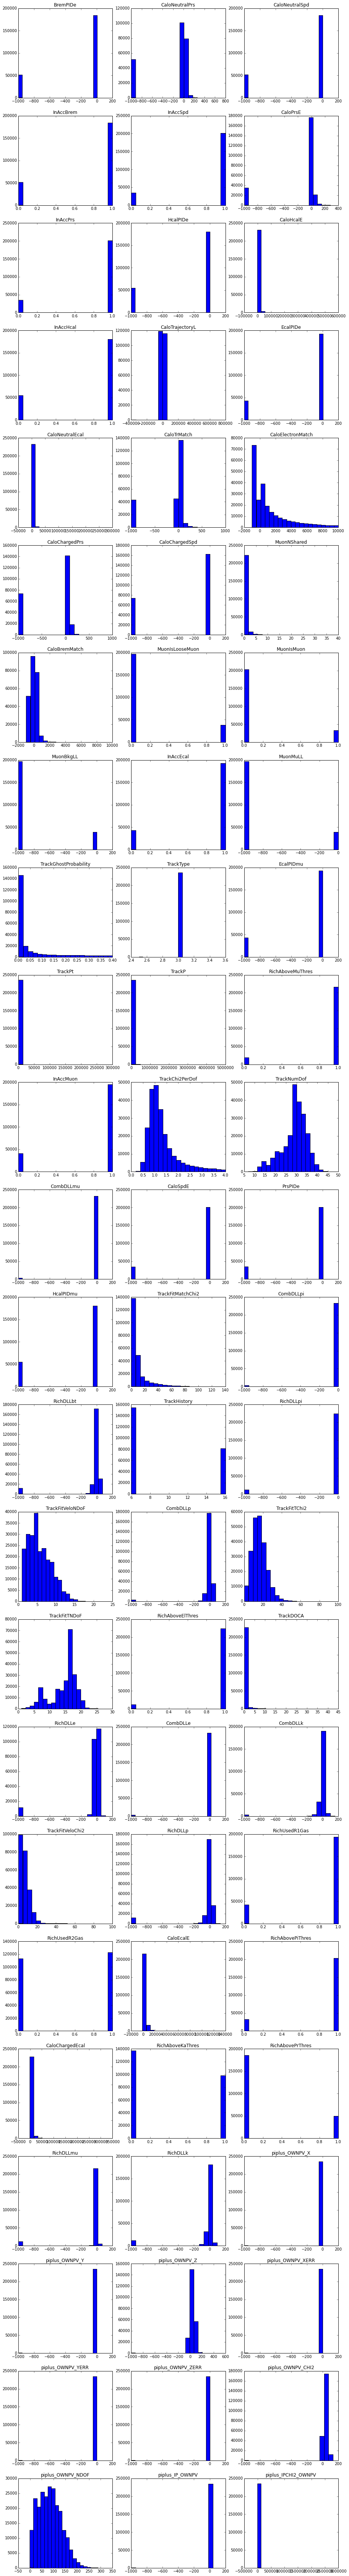

In [13]:
i=0
plt.figure(figsize=(15, 5 * (len(features)//3 + 1)))

for f in features:
    
    plt.subplot(len(features)//3 + 1, 3, i+1)
    plt.title(f)
    plt.hist(data[f].values, bins=20)
    
    i+=1
    
plt.show()

# Categorical features histograms

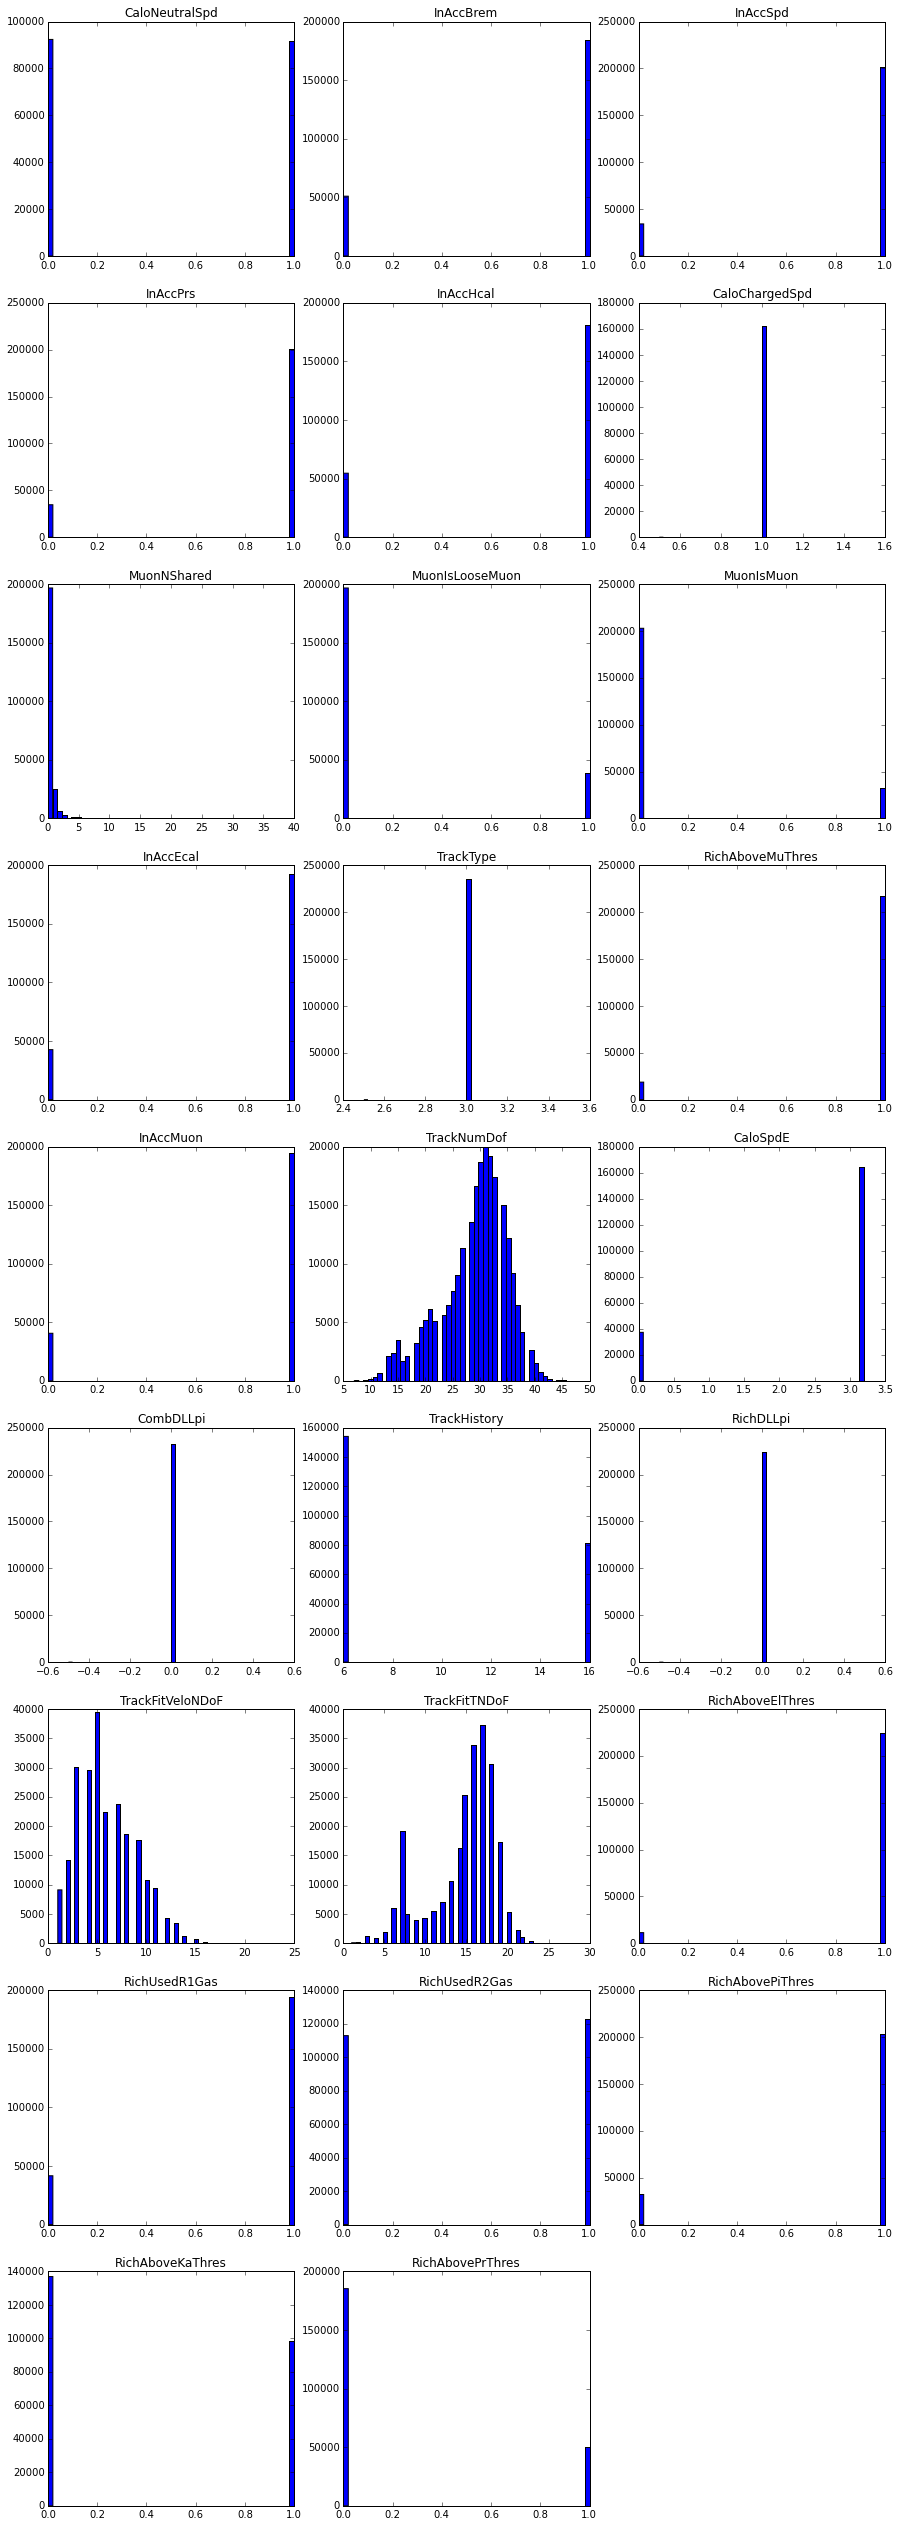

In [10]:
i=0
categorical_features = []
plt.figure(figsize=(15, 5 * (len(features)//3 + 1)))

for f in features:
    
    feature_value = data[f].values
    feature_value = feature_value[feature_value != -999.0]
    
    if len(numpy.unique(feature_value)) <= 50:
        
        categorical_features += [f]
    
        plt.subplot(len(features)//3 + 1, 3, i+1)
        plt.title(f)
        plt.hist(feature_value, bins=50)

        i+=1
    
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler, Imputer, StandardScaler

imp = Imputer(missing_values=-999.0, strategy='most_frequent', axis=0, copy=True)
imp.fit(data[categorical_features].values)

Imputer(axis=0, copy=True, missing_values=-999.0, strategy='most_frequent',
    verbose=0)

In [12]:
categorical_features

['CaloNeutralSpd',
 'InAccBrem',
 'InAccSpd',
 'InAccPrs',
 'InAccHcal',
 'CaloChargedSpd',
 'MuonNShared',
 'MuonIsLooseMuon',
 'MuonIsMuon',
 'InAccEcal',
 'TrackType',
 'RichAboveMuThres',
 'InAccMuon',
 'TrackNumDof',
 'CaloSpdE',
 'CombDLLpi',
 'TrackHistory',
 'RichDLLpi',
 'TrackFitVeloNDoF',
 'TrackFitTNDoF',
 'RichAboveElThres',
 'RichUsedR1Gas',
 'RichUsedR2Gas',
 'RichAbovePiThres',
 'RichAboveKaThres',
 'RichAbovePrThres']

# Train

In [13]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.1 * (labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.470898  ,  0.78906465,  4.19695187])

In [14]:
for i in numpy.unique(labels):
    print "Weight of class %d is " % i, weights[labels == i][0]

Weight of class 0 is  0.470898
Weight of class 1 is  4.19695187166
Weight of class 2 is  0.789064646939
Weight of class 3 is  0.470898
Weight of class 4 is  0.470898
Weight of class 5 is  0.470898


In [15]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

# Random Forest

In [16]:
X_train = imp.transform(data[categorical_features].loc[train_inds].values)
y_train = labels_train

X_test = imp.transform(data[categorical_features].loc[test_inds].values)
y_test = labels_test

In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, 
                             max_features=None, 
                             max_depth=None, 
                             n_jobs=4, 
                             bootstrap=True, 
                             min_samples_leaf=10)
clf.fit(X_train, y_train, weights_train)

CPU times: user 19min 44s, sys: 11.1 s, total: 19min 55s
Wall time: 11min 25s


In [221]:
feature_ims = pandas.DataFrame()
feature_ims['Features'] = categorical_features
feature_ims['Importances'] = clf.feature_importances_
feature_ims.sort(columns=['Importances'], ascending=False)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Features,Importances
8,MuonIsMuon,0.367465
13,TrackNumDof,0.138235
19,TrackFitTNDoF,0.110020
18,TrackFitVeloNDoF,0.092889
24,RichAboveKaThres,0.057176
23,RichAbovePiThres,0.040667
16,TrackHistory,0.037240
0,CaloNeutralSpd,0.028254
14,CaloSpdE,0.024418
6,MuonNShared,0.016918


In [18]:
probas = clf.predict_proba(X_test)

In [19]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

1.3975272552278781

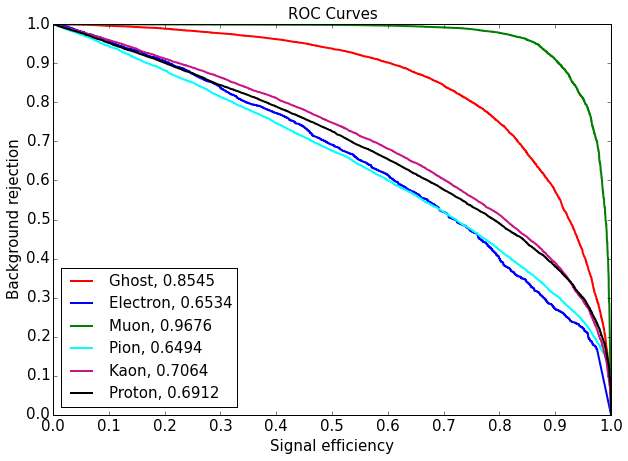

In [20]:
import os, sys
sys.path.append('../python')
import utils

utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

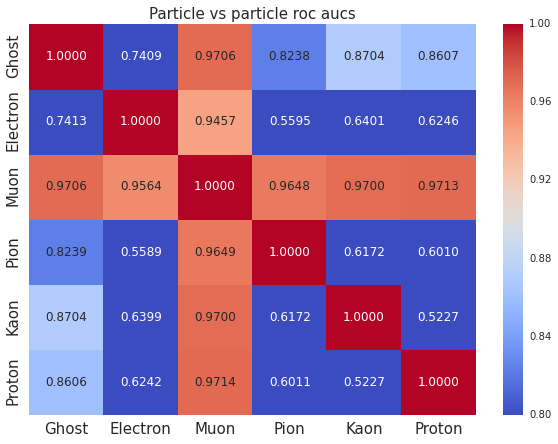

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.740867,0.970633,0.823829,0.870362,0.860718
Electron,0.741273,1.000000,0.945735,0.559525,0.640126,0.624633
Muon,0.970569,0.956391,1.000000,0.964816,0.969982,0.971308
Pion,0.823914,0.558908,0.964899,1.000000,0.617206,0.601036
Kaon,0.870444,0.639883,0.970017,0.617206,1.000000,0.522747
Proton,0.860641,0.624239,0.971430,0.601114,0.522667,1.000000


In [161]:
utils.get_roc_auc_matrix(labels_test, probas, particles, save_path=None, show=True)

# FastFM

In [154]:
import copy
import numpy

class OneVsRestClassifier(object):

    def __init__(self, estimator):
        """
        One vs Rest classifier based on an estimator.
        :param estimator: estimator with fit, predict, predict_proba mathods.
        :return:
        """

        self.estimator = estimator
        self.estimators_ = {}
        self.classes = []

    def fit(self, X, y, sample_weight=None):
        """
        Fit the classifier.
        :param X: the estimator's format, data
        :param y: array, shape = [n_samples], labels of classes [0, 1, 2, ..., n_classes - 1]
        :param sample_weight: None, 'balanced' or array, shape = [n_samples], sample weights.
        If 'balanced' sum of weights of positive and negative classes will be equal.
        :return:
        """

        self.classes = numpy.unique(y)

        for one_class in self.classes:

            y_class = (y == one_class) * 2. - 1. # !!!

            estimator = copy.copy(self.estimator)

            if sample_weight is None:

                estimator.fit(X, y_class)

            elif sample_weight == 'balanced':

                weights = (y == one_class) * len(y) / ((y == one_class).sum()) + \
                          (y != one_class) * len(y) / ((y != one_class).sum())

                estimator.fit(X, y_class, sample_weight = weights)

            else:

                estimator.fit(X, y_class, sample_weight)

            self.estimators_[one_class] = estimator

    def predict_proba(self, X):
        """
        Predict probabilities to belong to a class for the each class.
        :param X: the estimator's format, data
        :return: ndarray, shape = [n_samples, n_classes], probabiities.
        """

        probas = numpy.zeros((X.shape[0], len(self.classes)))

        for num, one_class in enumerate(self.classes):

            one_proba = self.estimators_[one_class].predict_proba(X)

            probas[:, num] = one_proba

        return probas

    def predict(self, X):
        """
        Predict classes.
        :param X: the estimator's format, data
        :return: array, shape = [n_samples], class labels [0, 1, 2, ..., n_classes - 1]
        """

        probas = self.predict_proba(X)

        predictions = probas.argmax(axis=1)

        return predictions


In [151]:
from sklearn.feature_extraction import DictVectorizer

X_train_fm = [ {v: k for k, v in dict(zip(i, range(len(i)))).items()}  for i in X_train]
X_test_fm = [ {v: k for k, v in dict(zip(i, range(len(i)))).items()}  for i in X_test]

v = DictVectorizer()
X_train_fm = v.fit_transform(X_train_fm)
X_test_fm = v.transform(X_test_fm)

In [214]:
%%time
from fastFM import sgd
fm = sgd.FMClassification(n_iter=10000000, init_stdev=0.1, l2_reg_w=0., l2_reg_V=0., l2_reg=0., rank=8, step_size=0.001)

fm_all = OneVsRestClassifier(fm)
fm_all.fit(X_train_fm, y_train, None)

CPU times: user 2min 20s, sys: 97 ms, total: 2min 20s
Wall time: 2min 20s


In [215]:
probas_fm = fm_all.predict_proba(X_test_fm)

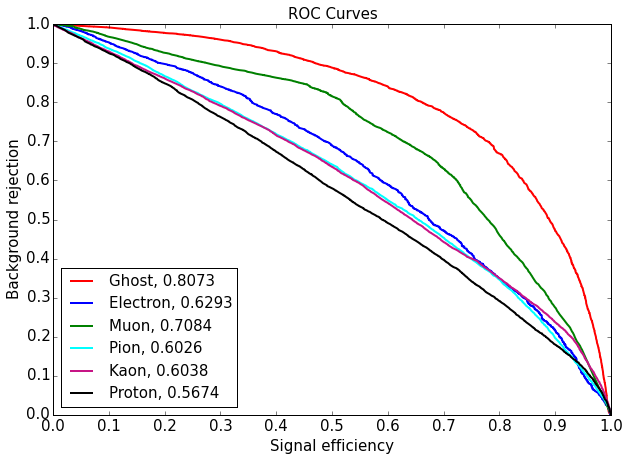

In [216]:
import os, sys
sys.path.append('../python')
import utils

utils.get_roc_curves(labels_test, probas_fm, particles, save_path=None, show=True)

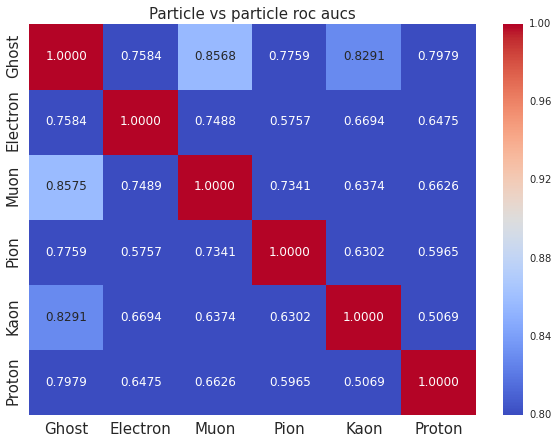

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.758431,0.856766,0.775910,0.829124,0.797932
Electron,0.758431,1.000000,0.748833,0.575675,0.669379,0.647491
Muon,0.857507,0.748855,1.000000,0.734073,0.637429,0.662589
Pion,0.775910,0.575675,0.734073,1.000000,0.630173,0.596509
Kaon,0.829124,0.669379,0.637430,0.630173,1.000000,0.506927
Proton,0.797931,0.647491,0.662589,0.596509,0.506927,1.000000


In [217]:
utils.get_roc_auc_matrix(labels_test, probas_fm, particles, save_path=None, show=True)